<a href="https://colab.research.google.com/github/aman0603/classification_ml/blob/main/blended_catboost%2Blightbgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir('/content/drive/MyDrive/kaggle_comp')

In [62]:
os.getcwd()

'/content/drive/MyDrive/kaggle_comp'

In [3]:
os.listdir()

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'catboost_info',
 '.ipynb_checkpoints',
 'submission.csv']

In [4]:
data=pd.read_csv('train.csv')
data.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

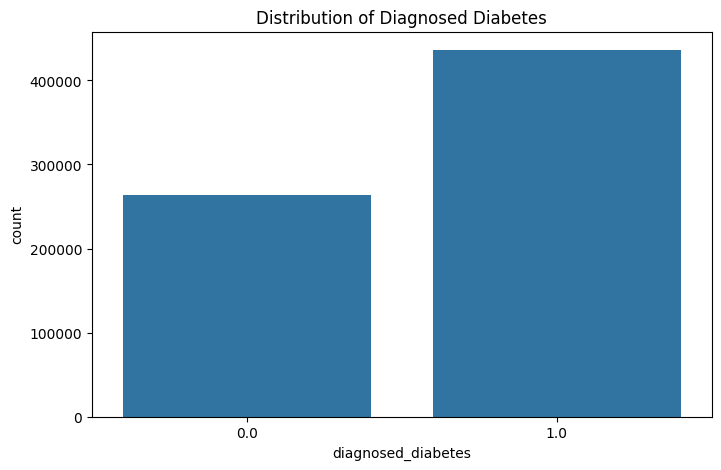

Target Distribution:
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


In [6]:
target_col = 'diagnosed_diabetes'
plt.figure(figsize=(8, 5))
sns.countplot(x=target_col, data=data)
plt.title('Distribution of Diagnosed Diabetes')
plt.show()

counts = data[target_col].value_counts(normalize=True)
print(f"Target Distribution:\n{counts}")


In [7]:
data.isnull().sum()

,0
id,0
age,0
alcohol_consumption_per_week,0
physical_activity_minutes_per_week,0
diet_score,0
sleep_hours_per_day,0
screen_time_hours_per_day,0
bmi,0
waist_to_hip_ratio,0
systolic_bp,0


Correlation of continuous features with target:
diagnosed_diabetes                    1.000000
family_history_diabetes               0.211064
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
diastolic_bp                          0.036271
hypertension_history                  0.029979
cardiovascular_history                0.024746
heart_rate                            0.023865
screen_time_hours_per_day             0.018213
sleep_hours_per_day                   0.003509
alcohol_consumption_per_week          0.002991
diet_score                           -0.050119
hdl_cholesterol                      -0.053231
physical_activity_minutes_per_week   -0.169789
Name: diagnosed_diabetes, dtype: float64


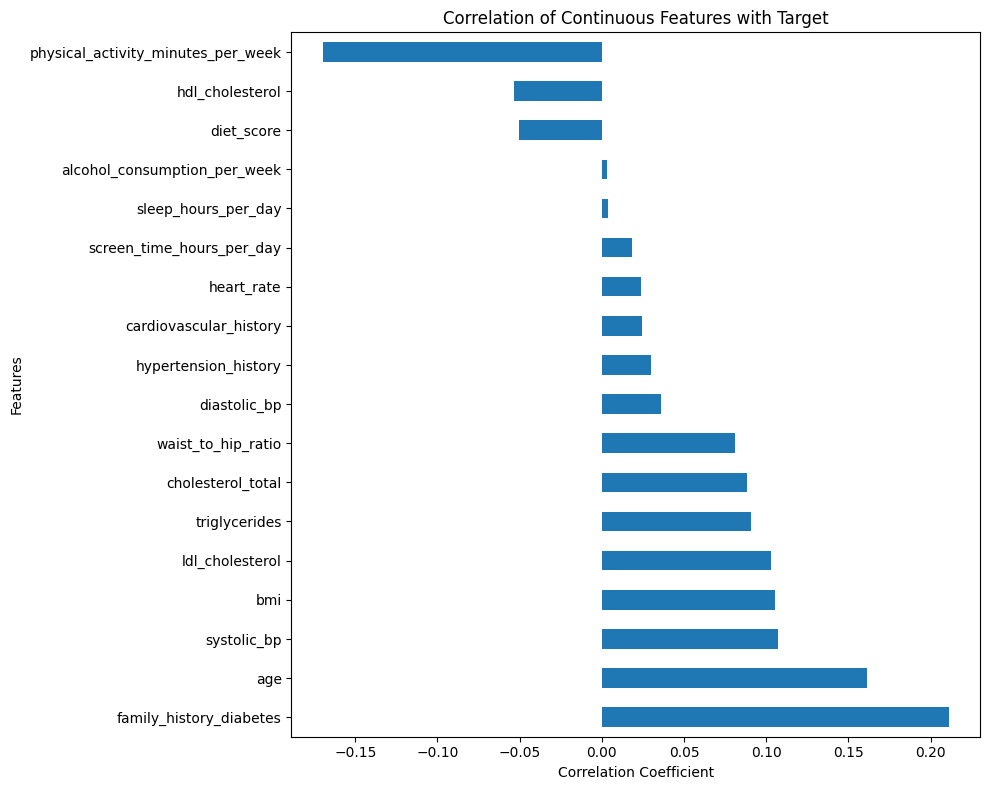

In [8]:
continuous_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in continuous_features:
    continuous_features.remove('id')
if target_col in continuous_features:
    continuous_features.remove(target_col)

correlations = data[continuous_features + [target_col]].corr()[target_col].sort_values(ascending=False)
print("Correlation of continuous features with target:")
print(correlations)

plt.figure(figsize=(10, 8))
correlations.drop(target_col).plot(kind='barh')
plt.title('Correlation of Continuous Features with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Baseline Model Training and Validation

We will use a Stratified 5-Fold Cross-Validation approach with ROC-AUC as the evaluation metric. The baseline model will be a `CatBoostClassifier` with default hyperparameters.

In [9]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [11]:
X = data.drop(columns=['id', 'diagnosed_diabetes'])
y = data['diagnosed_diabetes']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
feature_importances = []

In [12]:
# Identify Categorical Features by Dtype
cat_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"Detected categorical features: {cat_features}")

Detected categorical features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [15]:
print("Starting Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=2500,
        learning_rate=0.04,
        depth=8,
        l2_leaf_reg=8,
        random_strength=1.0,
        bootstrap_type='Bernoulli',
        subsample=0.8,
        eval_metric='AUC',
        random_seed=42,
        verbose=100,
        cat_features=cat_features,
        task_type="GPU",
        devices="0"
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)
    feature_importances.append(model.get_feature_importance())

    print(f"Fold {fold + 1} AUC: {auc:.4f}")

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nCross-Validation Results:")
print(f"Mean ROC-AUC: {mean_auc:.4f} (+/- {std_auc:.4f})")

Starting Cross-Validation...


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6834709	best: 0.6834709 (0)	total: 122ms	remaining: 5m 4s
100:	test: 0.7072422	best: 0.7072422 (100)	total: 8.51s	remaining: 3m 22s
200:	test: 0.7123818	best: 0.7123818 (200)	total: 17s	remaining: 3m 14s
300:	test: 0.7164569	best: 0.7164569 (300)	total: 26s	remaining: 3m 10s
400:	test: 0.7197182	best: 0.7197242 (398)	total: 33.8s	remaining: 2m 56s
500:	test: 0.7219324	best: 0.7219324 (500)	total: 42.7s	remaining: 2m 50s
600:	test: 0.7230588	best: 0.7230655 (594)	total: 51.6s	remaining: 2m 43s
700:	test: 0.7238769	best: 0.7238769 (700)	total: 59.5s	remaining: 2m 32s
800:	test: 0.7242898	best: 0.7242898 (800)	total: 1m 9s	remaining: 2m 27s
900:	test: 0.7246840	best: 0.7246840 (900)	total: 1m 18s	remaining: 2m 19s
1000:	test: 0.7250250	best: 0.7250250 (1000)	total: 1m 26s	remaining: 2m 9s
1100:	test: 0.7252547	best: 0.7252573 (1098)	total: 1m 35s	remaining: 2m 1s
1200:	test: 0.7254826	best: 0.7254829 (1183)	total: 1m 44s	remaining: 1m 52s
1300:	test: 0.7255539	best: 0.7255539 (

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6831811	best: 0.6831811 (0)	total: 110ms	remaining: 4m 35s
100:	test: 0.7052584	best: 0.7052584 (100)	total: 9.17s	remaining: 3m 37s
200:	test: 0.7111109	best: 0.7111109 (200)	total: 18s	remaining: 3m 26s
300:	test: 0.7147861	best: 0.7147861 (300)	total: 25.8s	remaining: 3m 8s
400:	test: 0.7179301	best: 0.7179301 (400)	total: 34.5s	remaining: 3m
500:	test: 0.7200039	best: 0.7200039 (500)	total: 42.8s	remaining: 2m 50s
600:	test: 0.7211089	best: 0.7211089 (600)	total: 51.2s	remaining: 2m 41s
700:	test: 0.7217029	best: 0.7217041 (699)	total: 1m	remaining: 2m 34s
800:	test: 0.7221874	best: 0.7221877 (799)	total: 1m 8s	remaining: 2m 24s
900:	test: 0.7225378	best: 0.7225384 (898)	total: 1m 17s	remaining: 2m 16s
1000:	test: 0.7227199	best: 0.7227247 (996)	total: 1m 25s	remaining: 2m 8s
1100:	test: 0.7229584	best: 0.7229587 (1092)	total: 1m 33s	remaining: 1m 59s
1200:	test: 0.7231728	best: 0.7231728 (1200)	total: 1m 42s	remaining: 1m 51s
1300:	test: 0.7233426	best: 0.7233426 (1300)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6849873	best: 0.6849873 (0)	total: 113ms	remaining: 4m 41s
100:	test: 0.7055445	best: 0.7055445 (100)	total: 8.14s	remaining: 3m 13s
200:	test: 0.7114050	best: 0.7114050 (200)	total: 16.9s	remaining: 3m 12s
300:	test: 0.7153151	best: 0.7153151 (300)	total: 25.7s	remaining: 3m 7s
400:	test: 0.7186382	best: 0.7186382 (400)	total: 33.6s	remaining: 2m 55s
500:	test: 0.7207815	best: 0.7207815 (500)	total: 42.6s	remaining: 2m 49s
600:	test: 0.7218090	best: 0.7218095 (599)	total: 50.9s	remaining: 2m 40s
700:	test: 0.7226245	best: 0.7226245 (700)	total: 59.4s	remaining: 2m 32s
800:	test: 0.7233492	best: 0.7233492 (800)	total: 1m 8s	remaining: 2m 24s
900:	test: 0.7237506	best: 0.7237506 (900)	total: 1m 16s	remaining: 2m 15s
1000:	test: 0.7240278	best: 0.7240282 (998)	total: 1m 25s	remaining: 2m 7s
1100:	test: 0.7242559	best: 0.7242559 (1100)	total: 1m 34s	remaining: 1m 59s
1200:	test: 0.7244091	best: 0.7244134 (1199)	total: 1m 42s	remaining: 1m 50s
1300:	test: 0.7245899	best: 0.72458

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6848610	best: 0.6848610 (0)	total: 111ms	remaining: 4m 36s
100:	test: 0.7068031	best: 0.7068031 (100)	total: 9.23s	remaining: 3m 39s
200:	test: 0.7131345	best: 0.7131345 (200)	total: 17.3s	remaining: 3m 17s
300:	test: 0.7166427	best: 0.7166427 (300)	total: 26s	remaining: 3m 10s
400:	test: 0.7198107	best: 0.7198107 (400)	total: 35s	remaining: 3m 3s
500:	test: 0.7218448	best: 0.7218448 (500)	total: 42.8s	remaining: 2m 50s
600:	test: 0.7230176	best: 0.7230206 (599)	total: 51.6s	remaining: 2m 43s
700:	test: 0.7238069	best: 0.7238069 (700)	total: 1m	remaining: 2m 35s
800:	test: 0.7243915	best: 0.7243915 (800)	total: 1m 8s	remaining: 2m 25s
900:	test: 0.7248196	best: 0.7248196 (900)	total: 1m 17s	remaining: 2m 17s
1000:	test: 0.7251310	best: 0.7251310 (1000)	total: 1m 26s	remaining: 2m 8s
1100:	test: 0.7252870	best: 0.7252925 (1084)	total: 1m 34s	remaining: 1m 59s
1200:	test: 0.7254596	best: 0.7254645 (1198)	total: 1m 43s	remaining: 1m 51s
1300:	test: 0.7255867	best: 0.7255867 (13

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6828320	best: 0.6828320 (0)	total: 172ms	remaining: 7m 8s
100:	test: 0.7073507	best: 0.7073507 (100)	total: 9.26s	remaining: 3m 40s
200:	test: 0.7131835	best: 0.7131835 (200)	total: 18.4s	remaining: 3m 30s
300:	test: 0.7167664	best: 0.7167664 (300)	total: 26.2s	remaining: 3m 11s
400:	test: 0.7197247	best: 0.7197247 (400)	total: 35.1s	remaining: 3m 3s
500:	test: 0.7214435	best: 0.7214435 (500)	total: 43.9s	remaining: 2m 55s
600:	test: 0.7226015	best: 0.7226015 (600)	total: 56.4s	remaining: 2m 58s
700:	test: 0.7233079	best: 0.7233079 (700)	total: 1m 4s	remaining: 2m 44s
800:	test: 0.7238820	best: 0.7238820 (800)	total: 1m 12s	remaining: 2m 34s
900:	test: 0.7243663	best: 0.7243663 (900)	total: 1m 21s	remaining: 2m 24s
1000:	test: 0.7247657	best: 0.7247657 (1000)	total: 1m 29s	remaining: 2m 14s
1100:	test: 0.7250247	best: 0.7250247 (1100)	total: 1m 38s	remaining: 2m 5s
1200:	test: 0.7251673	best: 0.7251718 (1199)	total: 1m 46s	remaining: 1m 55s
1300:	test: 0.7253343	best: 0.7253

### Base model

In [13]:
base_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    cat_features=cat_features,
    verbose=200,
    task_type="GPU",
    devices="0"
)

base_model.fit(X, y)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 88.4ms	remaining: 1m 28s
200:	total: 13.7s	remaining: 54.5s
400:	total: 26.7s	remaining: 39.9s
600:	total: 41.2s	remaining: 27.4s
800:	total: 54.5s	remaining: 13.5s
999:	total: 1m 12s	remaining: 0us


### tuned_model

In [14]:
tuned_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.025,
    depth=6,
    l2_leaf_reg=18,
    bootstrap_type='Bernoulli',
    subsample=0.9,
    random_strength=0.7,
    cat_features=cat_features,
    eval_metric='AUC',
    random_seed=42,
    verbose=200,
    task_type="GPU",
    devices="0"
)

tuned_model.fit(X, y)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 180ms	remaining: 4m 30s
200:	total: 13.9s	remaining: 1m 30s
400:	total: 27.2s	remaining: 1m 14s
600:	total: 40.3s	remaining: 1m
800:	total: 53.8s	remaining: 47s
1000:	total: 1m 7s	remaining: 33.6s
1200:	total: 1m 20s	remaining: 20.1s
1400:	total: 1m 34s	remaining: 6.65s
1499:	total: 1m 41s	remaining: 0us


In [15]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
0,700000,45,4,100,4.3,6.8,6.2,25.5,0.84,123,...,111,Female,White,Highschool,Middle,Former,Employed,0,0,0
1,700001,35,1,87,3.5,4.6,9.0,28.6,0.88,120,...,145,Female,White,Highschool,Middle,Never,Unemployed,0,0,0
2,700002,45,1,61,7.6,6.8,7.0,28.5,0.94,112,...,184,Male,White,Highschool,Low,Never,Employed,0,0,0
3,700003,55,2,81,7.3,7.3,5.0,26.9,0.91,114,...,128,Male,White,Graduate,Middle,Former,Employed,0,0,0
4,700004,77,2,29,7.3,7.6,8.5,22.0,0.83,131,...,133,Male,White,Graduate,Low,Current,Unemployed,0,0,0


### Lightbgm

In [16]:
from sklearn.preprocessing import LabelEncoder

X_lgb = X.copy()
test_lgb = test_data.copy()

for col in cat_features:
    le = LabelEncoder()
    X_lgb[col] = le.fit_transform(X_lgb[col])
    test_lgb[col] = le.transform(test_lgb[col])

In [17]:
import lightgbm as lgb

In [18]:
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "lambda_l2": 5,
    "verbose": -1
}

train_set = lgb.Dataset(X_lgb, y)
model_lgb = lgb.train(params, train_set, num_boost_round=2000)


### Prediction

In [19]:
base_model.save_model('catboost_base_model.cbm')
tuned_model.save_model('catboost_tuned_model.cbm')

model_lgb.save_model('lightgbm_model.txt')

print("Models saved successfully: catboost_base_model.cbm, catboost_tuned_model.cbm, lightgbm_model.txt")

Models saved successfully: catboost_base_model.cbm, catboost_tuned_model.cbm, lightgbm_model.txt


In [27]:
pred_base = base_model.predict_proba(test_data[X.columns])[:,1]
pred_tuned =tuned_model.predict_proba(test_data[X.columns])[:,1]
pred_lgb = model_lgb.predict(test_lgb[X.columns])
final_pred = 0.35 * pred_base + 0.25 * pred_tuned + 0.40 * pred_lgb

In [28]:
# preds = final_model.predict_proba(test_data[X.columns])[:, 1]

In [29]:
# preds.shape
final_pred
final_pred.shape

(300000,)

In [32]:
submission = pd.DataFrame({
    "id": test_data["id"],
    "diagnosed_diabetes": final_pred
})
submission.to_csv("submission.csv", index=False)

In [33]:
submission.head()

,id,diagnosed_diabetes
0,700000,0.512023
1,700001,0.672221
2,700002,0.765749
3,700003,0.412455
4,700004,0.910987
